<a href="https://colab.research.google.com/github/SovetovAleksey/PyTorch/blob/main/HW_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 10. Распознавание лиц и эмоций.
## **Задание по итогам курса:**

- (упрощенное/для тех, у кого нет вебкамеры)
    1. Нужно написать приложение, которое будет получать на вход *изображение*.
    2. В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
    3. На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

- (более сложное)
    1. Нужно написать приложение, которое будет считывать и выводить кадры с *веб-камеры*.
    2. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
    3. Человек показывает жесты руками, а алгоритм должен считать их и классифицировать.
____________________
- Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.
- Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab


У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ

In [ ]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/gti-upm/leapgestrecog")

Skipping, found downloaded files in ".\leapgestrecog" (use force=True to force download)


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

In [ ]:
DATA_ROOT = 'leapgestrecog/leapGestRecog'

Зададим трансформации для трейна и теста. Для Grayscale задаем число выходных слоев, равное 3, т.к. resnet не принимает одноканальные изображения

In [ ]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Картинки черно-белые
                         tt.Resize([128, 128]),
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor(),                       # Приведение к тензору
                         ])

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])

Сохраним имена классов через загрузку одной из папок:

In [ ]:
tmp_ds = ImageFolder(os.path.join(DATA_ROOT, '00'))
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

Создадим тренировочный и тестовый датасеты с одними и теми же картинками, но с разным препроцессингом:

In [ ]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
  train_ds = ImageFolder(os.path.join(DATA_ROOT, dir), train_tfms)
  test_ds = ImageFolder(os.path.join(DATA_ROOT, dir), test_tfms)
  train_ds_list.append(train_ds)
  test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

Общее количество картинок:

In [ ]:
LEN_DS = len(train_ds)
LEN_DS

40000

Функция преобразования номера класса в его название:

In [ ]:
def digit_to_classname(digit):
  for idx, itm in enumerate(CLASSES_NAME):
    if idx == digit:
      return itm

Посмотрим распределения классов в датасете:

In [ ]:
from collections import Counter
tmp_list = []
for _, cls in train_ds:
  tmp_list.append(digit_to_classname(cls))
cnt = Counter(tmp_list)
print(dict(cnt))

{'01_palm': 4000, '02_l': 4000, '03_fist': 4000, '04_fist_moved': 4000, '05_thumb': 4000, '06_index': 4000, '07_ok': 4000, '08_palm_moved': 4000, '09_c': 4000, '10_down': 4000}


Распределение классов равное.

Разделим датасет на тренировачный и тестовый:

In [ ]:
torch.manual_seed(1)

val_split = 0.2
split = int(LEN_DS * val_split)
indices = torch.randperm(LEN_DS)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(32000, 8000)

Проверим размерность случайного тензора в датасете:

In [ ]:
train_ds[15000][0].size()

torch.Size([3, 128, 128])

Проверим дисбаланс классов:

In [ ]:
from collections import Counter
tmp_list = []
for _, cls in train_ds:
  tmp_list.append(digit_to_classname(cls))
cnt = Counter(tmp_list)
print(dict(cnt))

{'08_palm_moved': 3172, '03_fist': 3186, '10_down': 3221, '02_l': 3209, '05_thumb': 3187, '01_palm': 3209, '04_fist_moved': 3208, '07_ok': 3180, '09_c': 3219, '06_index': 3209}


Дисбаланс классов есть, но он очень не существенный

Создадим даталоадеры:

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

Выведем случайное изображение в тестовом загрузчике:

torch.Size([3, 128, 128])
tensor(1) 02_l


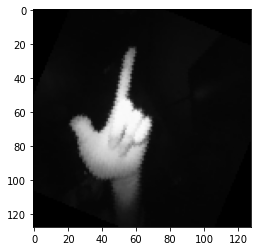

In [ ]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)) #, cmap='gray')
    break

Функция для визуалиции батча:

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Визуализируем батч:

torch.Size([3, 128, 128])


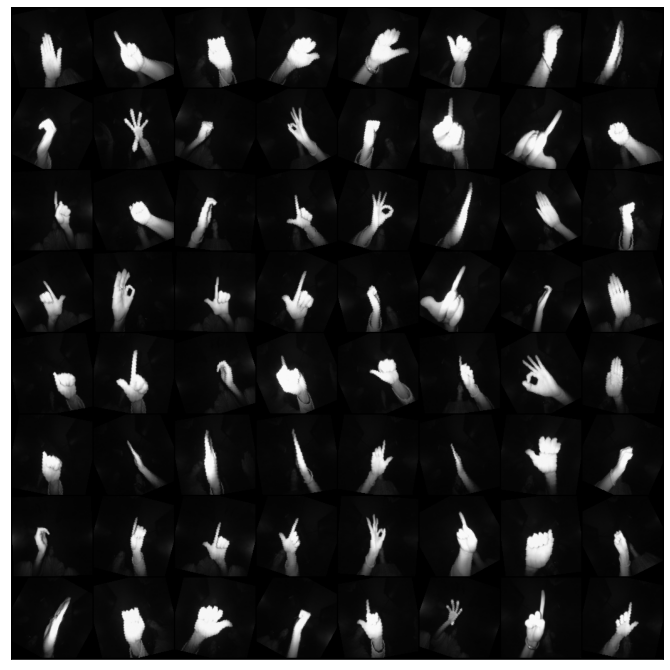

In [ ]:
show_batch(train_dl)

Определим устройство для работы нейросетей:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Возьмем для классификации предобученную сеть resnet50:

In [ ]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Professional/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 43.5MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Запретим весам обучаться

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

Посмотрим на слои нейросети. Нас интересует последний классификационный слой, который мы будем переобучать:

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Перезапишем последний классификационный слой, и убедимся, что остальные слои не будут обучаться:

In [ ]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES_NAME))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Создадим список обучаемых параметров и подадим его в оптимизатор. Также инициализируем функцию потерь:

In [ ]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

Инициализируем функцию для обучения сети:

In [ ]:
from time import time
# from tqdm import tqdm

def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()

        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}')
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')

    return model, train_losses, val_losses

Обучим сеть на 5 эпохах:

In [ ]:
print_every = 50
num_epoch = 5

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[5]. Batch [50]/[500]. Train loss 1.976. Train acc 32.375. Val loss 2.015. Val acc 30.913. Took 785.623 seconds
Epoch [1]/[5]. Batch [100]/[500]. Train loss 1.894. Train acc 35.562. Val loss 1.783. Val acc 39.562. Took 755.142 seconds
Epoch [1]/[5]. Batch [150]/[500]. Train loss 1.803. Train acc 38.688. Val loss 1.697. Val acc 41.287. Took 765.555 seconds
Epoch [1]/[5]. Batch [200]/[500]. Train loss 1.743. Train acc 40.547. Val loss 1.665. Val acc 39.562. Took 774.695 seconds
Epoch [1]/[5]. Batch [250]/[500]. Train loss 1.701. Train acc 41.494. Val loss 1.579. Val acc 43.750. Took 765.803 seconds
Epoch [1]/[5]. Batch [300]/[500]. Train loss 1.667. Train acc 42.510. Val loss 1.586. Val acc 44.012. Took 765.738 seconds
Epoch [1]/[5]. Batch [350]/[500]. Train loss 1.634. Train acc 43.442. Val loss 1.578. Val acc 43.562. Took 758.926 seconds
Epoch [1]/[5]. Batch [400]/[500]. Train loss 1.612. Train acc 44.012. Val loss 1.563. Val acc 44.050. Took 757.067 seconds
Epoch [1]/[5]. Ba

In [ ]:
resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=1
)

Epoch [1]/[1]. Batch [50]/[500]. Train loss 1.331. Train acc 49.688. Val loss 1.436. Val acc 47.812. Took 803.665 seconds
Epoch [1]/[1]. Batch [100]/[500]. Train loss 1.315. Train acc 49.312. Val loss 1.395. Val acc 48.500. Took 781.476 seconds
Epoch [1]/[1]. Batch [150]/[500]. Train loss 1.314. Train acc 49.521. Val loss 1.376. Val acc 48.013. Took 780.954 seconds
Epoch [1]/[1]. Batch [200]/[500]. Train loss 1.317. Train acc 49.453. Val loss 1.371. Val acc 47.938. Took 785.267 seconds
Epoch [1]/[1]. Batch [250]/[500]. Train loss 1.302. Train acc 49.713. Val loss 1.426. Val acc 47.400. Took 772.467 seconds
Epoch [1]/[1]. Batch [300]/[500]. Train loss 1.297. Train acc 49.688. Val loss 1.421. Val acc 46.950. Took 767.645 seconds
Epoch [1]/[1]. Batch [350]/[500]. Train loss 1.292. Train acc 49.808. Val loss 1.354. Val acc 47.850. Took 770.344 seconds
Epoch [1]/[1]. Batch [400]/[500]. Train loss 1.290. Train acc 49.887. Val loss 1.431. Val acc 46.438. Took 768.353 seconds
Epoch [1]/[1]. Ba

In [ ]:
torch.save(resnet, '/models')

In [ ]:
resnet = torch.load('/models')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Посмотрим предсказания по 5 картинкам из тестового датасета:

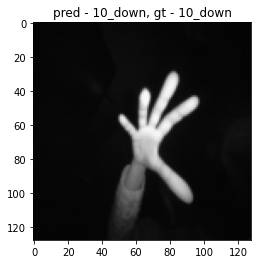

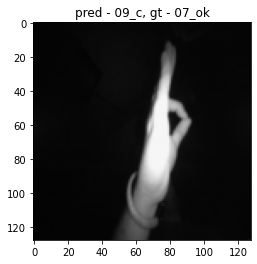

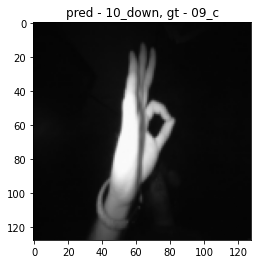

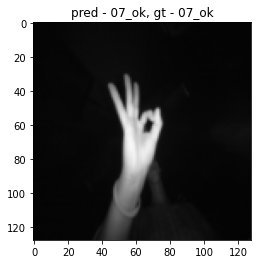

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = resnet(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break